### Importing Packages


In [524]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re

import json
import bbcode
from nltk.corpus import stopwords

import gensim
import nltk
from nltk import bigrams, trigrams
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
# from umap import UMAP
# from hdbscan import HDBSCAN
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
# from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# from bertopic import BERTopic

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Importing Dataset

In [525]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

def import_data_small(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, nrows=1000000)
    df = reduce_mem_usage(df)
    return df

In [526]:
# This code takes over a minute to run
steam_reviews = import_data_small('../apex_100000.csv')
steam_reviews.info()

Memory usage of dataframe is 8.96 MB
Memory usage after optimization is: 6.10 MB
Decreased by 31.9%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   recommendationid             100000 non-null  int32  
 1   author                       100000 non-null  object 
 2   language                     100000 non-null  object 
 3   review                       99996 non-null   object 
 4   timestamp_created            100000 non-null  int32  
 5   timestamp_updated            100000 non-null  int32  
 6   voted_up                     100000 non-null  float16
 7   votes_up                     100000 non-null  int16  
 8   votes_funny                  100000 non-null  int16  
 9   weighted_vote_score          100000 non-null  float16
 10  comment_count                100000 non-null  int16  
 11  steam_purchase    

In [527]:
# Check for NA values
steam_reviews.isna().sum()

recommendationid                    0
author                              0
language                            0
review                              4
timestamp_created                   0
timestamp_updated                   0
voted_up                            0
votes_up                            0
votes_funny                         0
weighted_vote_score                 0
comment_count                       0
steam_purchase                      0
received_for_free                   0
written_during_early_access         0
hidden_in_steam_china               0
steam_china_location           100000
primarily_steam_deck                0
dtype: int64

In [528]:
# Drop column and NA_values
steam_reviews = steam_reviews.drop(columns=['steam_china_location'])
steam_reviews.dropna(inplace=True)

In [529]:
steam_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             99996 non-null  int32  
 1   author                       99996 non-null  object 
 2   language                     99996 non-null  object 
 3   review                       99996 non-null  object 
 4   timestamp_created            99996 non-null  int32  
 5   timestamp_updated            99996 non-null  int32  
 6   voted_up                     99996 non-null  float16
 7   votes_up                     99996 non-null  int16  
 8   votes_funny                  99996 non-null  int16  
 9   weighted_vote_score          99996 non-null  float16
 10  comment_count                99996 non-null  int16  
 11  steam_purchase               99996 non-null  float16
 12  received_for_free            99996 non-null  float16
 13  written_during_early_

#### Filtering out the non english reviews using langdetect library and also the 'language' column value

- langdetect is a library that detects the language of a given text.
- 'language' column value is a string that represents the language of the review.
- However the 'language' column value is not always accurate, so we need to filter out the non english reviews using langdetect.

In [530]:
# Check the values in language column
steam_reviews['language'].value_counts()

language
english    99996
Name: count, dtype: int64

In [531]:
# Filter out reviews that are not in English
steam_reviews = steam_reviews[(steam_reviews['language'] == 'english')]
steam_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             99996 non-null  int32  
 1   author                       99996 non-null  object 
 2   language                     99996 non-null  object 
 3   review                       99996 non-null  object 
 4   timestamp_created            99996 non-null  int32  
 5   timestamp_updated            99996 non-null  int32  
 6   voted_up                     99996 non-null  float16
 7   votes_up                     99996 non-null  int16  
 8   votes_funny                  99996 non-null  int16  
 9   weighted_vote_score          99996 non-null  float16
 10  comment_count                99996 non-null  int16  
 11  steam_purchase               99996 non-null  float16
 12  received_for_free            99996 non-null  float16
 13  written_during_early_

In [532]:
from langdetect import detect, LangDetectException

# Function to detect if the review is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If the language detection fails, return False

# Apply the function to the 'review' column and create a new column 'is_english'
steam_reviews['is_english'] = steam_reviews['review'].apply(is_english)

# Filter the reviews that are in English
english_reviews = steam_reviews[steam_reviews['is_english']]

english_reviews.info()


<class 'pandas.core.frame.DataFrame'>
Index: 97078 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             97078 non-null  int32  
 1   author                       97078 non-null  object 
 2   language                     97078 non-null  object 
 3   review                       97078 non-null  object 
 4   timestamp_created            97078 non-null  int32  
 5   timestamp_updated            97078 non-null  int32  
 6   voted_up                     97078 non-null  float16
 7   votes_up                     97078 non-null  int16  
 8   votes_funny                  97078 non-null  int16  
 9   weighted_vote_score          97078 non-null  float16
 10  comment_count                97078 non-null  int16  
 11  steam_purchase               97078 non-null  float16
 12  received_for_free            97078 non-null  float16
 13  written_during_early_

In [533]:
english_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,primarily_steam_deck,is_english
0,78744058,"{'steamid': '76561198273957109', 'num_games_ow...",english,doesnt launch with origin\n\nedit: easy anti-c...,1604550435,1637267971,1.0,6141,913,0.975098,117,0.0,0.0,0.0,0.0,0.0,True
1,169339509,"{'steamid': '76561198091477605', 'num_games_ow...",english,"Now with the new battle pass system, I'm delet...",1720453574,1720453574,0.0,4279,81,0.974121,77,0.0,0.0,0.0,1.0,0.0,True
2,174544621,"{'steamid': '76561198009192271', 'num_games_ow...",english,"I've been playing this game since release, and...",1725817005,1725819183,0.0,447,18,0.958496,14,0.0,0.0,0.0,1.0,0.0,True
3,168328105,"{'steamid': '76561198295880474', 'num_games_ow...",english,Game freezes every session i play with the new...,1719498326,1719498326,0.0,1169,18,0.943359,0,0.0,0.0,0.0,1.0,0.0,True
4,108917721,"{'steamid': '76561198016708638', 'num_games_ow...",english,You open the game and finish your 3000 word es...,1643340456,1643340456,1.0,570,380,0.942383,59,0.0,0.0,0.0,0.0,0.0,True


#### Extracting out the list of values out of 'author' column

In [534]:
english_reviews['author'] = english_reviews['author'].apply(eval)
df_new = pd.json_normalize(english_reviews['author'])
df_new.head()

/var/folders/km/g10rkfjd3dq4472y1xj753pm0000gn/T/ipykernel_53000/3042607512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['author'] = english_reviews['author'].apply(eval)


,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,deck_playtime_at_review
0,76561198273957109,193,16,32762,0,13,1716413943,NaN
1,76561198091477605,29,4,99460,375,89667,1729034329,NaN
2,76561198009192271,0,1,105378,0,105376,1726009442,NaN
3,76561198295880474,41,4,40661,0,40421,1719746025,NaN
4,76561198016708638,160,36,33212,0,33212,1639107536,NaN


In [535]:
# Merge the two dataframes
english_reviews = pd.concat([english_reviews, df_new], axis=1)
english_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,primarily_steam_deck,is_english,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,deck_playtime_at_review
0,78744058.0,"{'steamid': '76561198273957109', 'num_games_ow...",english,doesnt launch with origin\n\nedit: easy anti-c...,1.604550e+09,1.637268e+09,1.0,6141.0,913.0,0.975098,...,0.0,True,76561198273957109,193.0,16.0,32762.0,0.0,13.0,1.716414e+09,NaN
1,169339509.0,"{'steamid': '76561198091477605', 'num_games_ow...",english,"Now with the new battle pass system, I'm delet...",1.720454e+09,1.720454e+09,0.0,4279.0,81.0,0.974121,...,0.0,True,76561198091477605,29.0,4.0,99460.0,375.0,89667.0,1.729034e+09,NaN
2,174544621.0,"{'steamid': '76561198009192271', 'num_games_ow...",english,"I've been playing this game since release, and...",1.725817e+09,1.725819e+09,0.0,447.0,18.0,0.958496,...,0.0,True,76561198009192271,0.0,1.0,105378.0,0.0,105376.0,1.726009e+09,NaN
3,168328105.0,"{'steamid': '76561198295880474', 'num_games_ow...",english,Game freezes every session i play with the new...,1.719498e+09,1.719498e+09,0.0,1169.0,18.0,0.943359,...,0.0,True,76561198295880474,41.0,4.0,40661.0,0.0,40421.0,1.719746e+09,NaN
4,108917721.0,"{'steamid': '76561198016708638', 'num_games_ow...",english,You open the game and finish your 3000 word es...,1.643340e+09,1.643340e+09,1.0,570.0,380.0,0.942383,...,0.0,True,76561198016708638,160.0,36.0,33212.0,0.0,33212.0,1.639108e+09,NaN


In [536]:
# Remove unnecessary columns
english_reviews_final = english_reviews.drop(columns=['timestamp_created', 'timestamp_updated', 'votes_funny', 'votes_up', 'weighted_vote_score', 'author', 'deck_playtime_at_review', 'last_played', 'playtime_last_two_weeks', 'playtime_forever', 'num_games_owned',
                                             'num_reviews','comment_count','is_english', 'hidden_in_steam_china','primarily_steam_deck', 'written_during_early_access', 'received_for_free', 'received_for_free', 'steam_purchase'])

In [537]:
english_reviews_final.head()

,recommendationid,language,review,voted_up,steamid,playtime_at_review
0,78744058.0,english,doesnt launch with origin\n\nedit: easy anti-c...,1.0,76561198273957109,13.0
1,169339509.0,english,"Now with the new battle pass system, I'm delet...",0.0,76561198091477605,89667.0
2,174544621.0,english,"I've been playing this game since release, and...",0.0,76561198009192271,105376.0
3,168328105.0,english,Game freezes every session i play with the new...,0.0,76561198295880474,40421.0
4,108917721.0,english,You open the game and finish your 3000 word es...,1.0,76561198016708638,33212.0


In [538]:
english_reviews_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99808 entries, 0 to 97045
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recommendationid    97078 non-null  float64
 1   language            97078 non-null  object 
 2   review              97078 non-null  object 
 3   voted_up            97078 non-null  float16
 4   steamid             97078 non-null  object 
 5   playtime_at_review  97078 non-null  float64
dtypes: float16(1), float64(2), object(3)
memory usage: 4.8+ MB


In [539]:
# Add new column with review_length
review_lengths = [len(str(x).split()) if isinstance(x, str) else 0 for x in english_reviews_final['review']]

print(len(review_lengths))
print(sum(review_lengths)/len(review_lengths)) # mean character length of a review

# Add the new column 'review_length' by handling non-string values
english_reviews_final['review_length'] = english_reviews_final['review'].map(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0)

99808
47.77977717217057


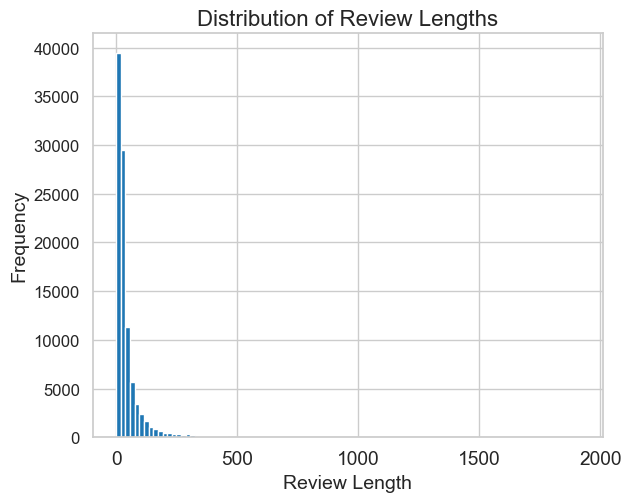

<Figure size 1000x1000 with 0 Axes>

In [540]:
plt.hist(english_reviews_final['review_length'], bins=100)
plt.tight_layout()
plt.yticks(fontsize=12) 

plt.xlabel('Review Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Review Lengths', fontsize=16)
plt.figure(figsize=(10, 10))

plt.show()

In [541]:
#cut off review lengths at the 25th percentile. 
#Short reviews contain too little info, but we can't discard too much data either.
np.percentile(english_reviews_final['review_length'],10) # If more than 3.0 words

steam_reviews_filtered = english_reviews_final[english_reviews_final['review_length'] > np.percentile(english_reviews_final['review_length'],10)].reset_index(drop=True) 
#Remove very short reviews that are likely to be junk

print('Min length:',min(steam_reviews_filtered['review_length']),'words') #shortest review length.

Min length: 12 words


In [542]:
import re

def is_mixed_language(text):
    # Define patterns for English and Chinese characters
    english_pattern = re.compile(r'[a-zA-Z]')
    chinese_pattern = re.compile(r'[\u4e00-\u9fff]')
    
    # Check if both English and Chinese characters are present
    contains_english = bool(english_pattern.search(text))
    contains_chinese = bool(chinese_pattern.search(text))
    
    # Return True if both languages are detected
    return contains_english and contains_chinese

# Assuming you meant 'steam_reviews_filtered' instead of 'team_reviews_filtered'
# Apply the function to detect mixed-language reviews
mixed_language_reviews = [review for review in steam_reviews_filtered['review'] if is_mixed_language(review)]

print("Mixed language reviews:")
print(len(mixed_language_reviews))
mixed_language_reviews_df = pd.DataFrame(mixed_language_reviews, columns=['review'])
mixed_language_reviews_df.head()

Mixed language reviews:
130


,review
0,got my 6 year old origin account with 40 games...
1,The only battle royale game I can play.(Just c...
2,"Rowenna is ugly as fuck, screw u all feminism ..."
3,沟槽的重生，脚步是没有的，反作弊是不运行的，分是要掉的，外挂是猖狂到，兹蹦是要改的，妈是要死...
4,"No mother's Respawn, plug-ins don't matter, bu..."


In [543]:
steam_reviews_filtered['review'].value_counts()

review
Before i played Apex Legends, i had a small wee-wee, no friends, no girlfriend, depression, and absolutely no life. These things haven't changed, but the game is pretty good.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [544]:
mask = steam_reviews_filtered['review'] == '▒█▀▀█ ▒█▀▀▀ ▒█▀▀█ ▀█▀ ▒█▀▀▀█ ▒█▄░▒█\n▒█▄▄▀ ▒█▀▀▀ ▒█░▄▄ ▒█░ ▒█░░▒█ ▒█▒█▒█\n▒█░▒█ ▒█▄▄▄ ▒█▄▄█ ▄█▄ ▒█▄▄▄█ ▒█░░▀█\n\n▒█░░░ ▒█▀▀▀█ ▒█▀▀█ ▒█░▄▀\n▒█░░░ ▒█░░▒█ ▒█░░░ ▒█▀▄░\n▒█▄▄█ ▒█▄▄▄█ ▒█▄▄█ ▒█░▒█\n\n▒█▀▀█ ▒█░▒█ ▀█▀ ▒█▄░▒█ ░█▀▀█\n▒█░░░ ▒█▀▀█ ▒█░ ▒█▒█▒█ ▒█▄▄█\n▒█▄▄█ ▒█░▒█ ▄█▄ ▒█░░▀█ ▒█░▒█'

steam_reviews_filtered.drop(steam_reviews_filtered[mask].index, inplace=True)

In [545]:
# Filter reviews that have more than 2 hours of playtime when written
minimum_playtime = 120 # playtime is recorded in minutes
steam_reviews_filtered = steam_reviews_filtered[steam_reviews_filtered['playtime_at_review'] >= minimum_playtime].reset_index(drop=True)

In [546]:
#Check how much data remains
len(steam_reviews_filtered)
len(steam_reviews)
percent_reduction = (len(steam_reviews) - len(steam_reviews_filtered)) / len(steam_reviews) * 100
print(f'The percentage reduction in the number of rows after filtering by length and playtime is by {percent_reduction:.2f}%')

The percentage reduction in the number of rows after filtering by length and playtime is by 18.22%


In [547]:
steam_reviews_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81781 entries, 0 to 81780
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recommendationid    81781 non-null  float64
 1   language            81781 non-null  object 
 2   review              81781 non-null  object 
 3   voted_up            81781 non-null  float16
 4   steamid             81781 non-null  object 
 5   playtime_at_review  81781 non-null  float64
 6   review_length       81781 non-null  int64  
dtypes: float16(1), float64(2), int64(1), object(3)
memory usage: 3.9+ MB


In [548]:
steam_reviews_filtered.head()

,recommendationid,language,review,voted_up,steamid,playtime_at_review,review_length
0,169339509.0,english,"Now with the new battle pass system, I'm delet...",0.0,76561198091477605,89667.0,17
1,174544621.0,english,"I've been playing this game since release, and...",0.0,76561198009192271,105376.0,294
2,168328105.0,english,Game freezes every session i play with the new...,0.0,76561198295880474,40421.0,13
3,108917721.0,english,You open the game and finish your 3000 word es...,1.0,76561198016708638,33212.0,315
4,170215617.0,english,"Apex is like your neighbor's sister, she treat...",0.0,76561199442688562,75521.0,66


#### Review Spam/Ham Problem
- Some reviews have been spammed multiple times, or just happen to come out the same.
- All reviewers' opinions are important, but repeated reviews sometimes originate from one player.
- Removing duplicates controls the "vocal minority" problem effectively.
- Need to clean away any text that is not strictly English. It is possible for text from other languages to be wrongly labelled as English. (Reviews scraped were all labelled as being in English)

In [549]:
# drop duplicate entries in reviews, because they are considered spam
steam_reviews_filtered2 = steam_reviews_filtered.drop_duplicates(subset=['steamid', 'review'])
len(steam_reviews_filtered2)

deduplicated_rows = abs(len(steam_reviews_filtered2) - len(steam_reviews_filtered)) #find out how many rows were removed during deduplication
print(deduplicated_rows)
print(deduplicated_rows/len(steam_reviews_filtered)) #Percentage of data that was duplicated

0
0.0


In [550]:
steam_reviews_filtered2.select_dtypes(include='O').describe()

,language,review,steamid
count,81781,81781,81781
unique,1,81455,81777
top,english,"Before i played Apex Legends, i had a small we...",76561197960330700
freq,81781,33,2


#### Text Cleaning


In [551]:
parser=bbcode.Parser()

In [552]:
with open('./contra_dict.txt') as contra_dict:  #open pre-defined dictionary of english contractions, saved separately to avoid clutter
    cList = json.load(contra_dict) #Load into a python dictionary

c_re = re.compile('(%s)' % '|'.join(cList.keys())) #joins the keys (contractions) using the pipe '|' as a separator, creating a string where each contraction is separated by the pipe character.
print(c_re)

def expandContractions(text, c_re=c_re):
    def replace(match): #match object as input and returns the expanded form of the contraction found in the match.
        return cList[match.group(0)] 
    return c_re.sub(replace, text.lower()) #Sub method:  replaces all occurrences of contractions in the text with their expanded forms

re.compile("(ain't|aren't|can't|can't've|'cause|could've|coulda|could of|couldn't|couldn't've|didn't|doesn't|don't|gotta|hadn't|hadn't've|hasn't|haven't|he'd|he'd've|he'll|he'll've|he's|how'd|how'd'y|how'll|how')


In [553]:
def remove_bbcode(text):
    # Pattern to match BBCode tags: [tag]content[/tag] or [tag]
    # It matches anything between square brackets, including the brackets.
    bbcode_pattern = re.compile(r'\[/?[^\]]+\]')

    text_without_bbcode = re.sub(bbcode_pattern, '', text)
    
    return text_without_bbcode

sample_text = "This is a [b]bold[/b] text and [url=http://example.com]link[/url]."
clean_text = remove_bbcode(sample_text)
print(clean_text)

This is a bold text and link.


In [554]:
# Load the regular expression library
import re

# Remove punctuation
steam_reviews_filtered2['review_processed'] = steam_reviews_filtered2['review'].map(lambda x: re.sub('[,.!?]', '', x))

# Convert the titles to lowercase
steam_reviews_filtered2['review_processed'] = steam_reviews_filtered2['review_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
steam_reviews_filtered2['review_processed'].head()

0    now with the new battle pass system i'm deleti...
1    i've been playing this game since release and ...
2    game freezes every session i play with the new...
3    you open the game and finish your 3000 word es...
4    apex is like your neighbor's sister she treats...
Name: review_processed, dtype: object

In [555]:
num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            '4':'four',
            '5':'five',
            '6':'six',
            '7':'seven',
            '8':'eight',
            '9':'nine',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123456789')  or (d in ['ii','iii']):
        word = num_dict[d] # Convert numbers 0123 to the number in word form
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))

    else:
        word = d
    
    return word

en_stopwords = stopwords.words('english')
en_stopwords.extend([
    # Generic filler words
    'good', 'better', 'best', 'great', 'like', 'love', 'play', 'played', 'thank', 'thanks', 'sir', 'game', 'games', 'fuck'
])
en_stopwords.extend([
    # Game-specific terms related to Apex Legends gameplay, features, and mechanics
    'apex', 'apex legends', 'legend', 'legends', 'arena', 'battle', 'royale', 'battlepass'
])
en_stopwords.extend([
    # Developers and publishers related to Apex Legends
    'respawn', 'ea', 'electronic arts', 'steam', 
])

en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]    #retain these for making n-grams

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words


In [556]:
# nltk.download('wordnet')
def parse_clean(text):
    
    text = remove_bbcode(text) # remove BBcode notations from text

    text = expandContractions(text) # expand contractions; return all text in lower case

    text = re.split(r'\W+',text) # separate words from punctuation (e.g. remove 's from "Cao Cao's")

    text = [num2word(w) for w in text] # convert single digits to words before word len check, or they will be lost
    
    # stemmer = PorterStemmer()
    # text = [stemmer.stem(w) for w in text]

    lemmatizer = WordNetLemmatizer()
    text =  [lemmatizer.lemmatize(word) for word in text]

    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet.
    text = [word for word in text if word not in en_stopwords and len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 

    text = [word for word in text if re.search('^[a-z]+$',word)]
    #clean_text = [num2word(w) for w in text] #just in case any lone numbers appeared after cleaning
    
    return text

se = "I love playing Apex Legends. It's the best battle royale game ever! Thanks Respawn for this great game. It's so fun to play with my friends. I'm so excited for the new season! I can't wait to see what they have in store for us."
print(parse_clean(se))

['playing', 'ever', 'fun', 'friend', 'excited', 'new', 'season', 'cannot', 'wait', 'see', 'store']


#### EDA


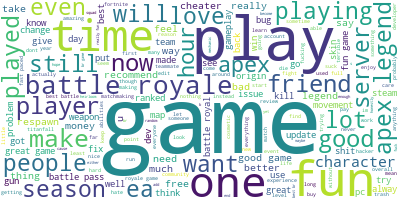

In [557]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(steam_reviews_filtered2['review_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

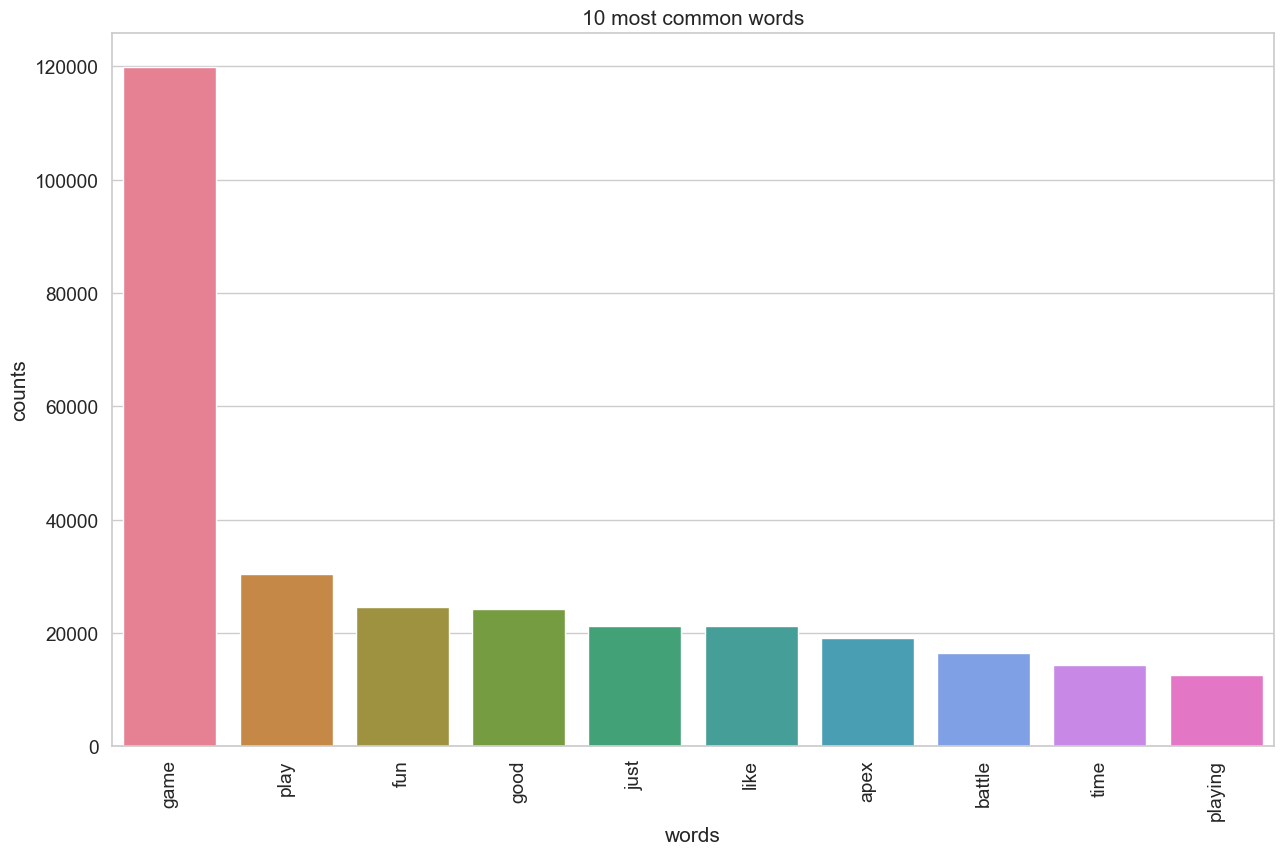

In [558]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(steam_reviews_filtered2['review_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### Tokenise into words

In [559]:
# Apply parse_clean() to every review into new column 'clean_review'
steam_reviews_filtered2['clean_review'] = steam_reviews_filtered2['review_processed'].map(lambda x: parse_clean(x))


In [560]:
def convert_to_str(list_review):
        return ' '.join(list_review)

steam_reviews_filtered2['clean_review_str'] = steam_reviews_filtered2['clean_review'].map(lambda x: convert_to_str(x))

 ### Bigram & Trigam Model

In [561]:
def create_bigrams(words_list):
    bigram_list = list(bigrams(words_list))
    bigram_strings = ['_'.join(bigram) for bigram in bigram_list]
    return bigram_strings

def create_trigrams(words_list):
    trigram_list = list(trigrams(words_list))
    trigram_strings = ['_'.join(trigram) for trigram in trigram_list]
    return trigram_strings


steam_reviews_filtered2['bigram_review'] = steam_reviews_filtered2['clean_review'].apply(create_bigrams)
steam_reviews_filtered2['trigram_review'] = steam_reviews_filtered2['clean_review'].apply(create_trigrams)

In [562]:
steam_reviews_filtered2.tail()

,recommendationid,language,review,voted_up,steamid,playtime_at_review,review_length,review_processed,clean_review,clean_review_str,bigram_review,trigram_review
81776,101005628.0,english,- Consistent problems with cheating\n- Consist...,0.0,76561199164701218,2557.0,62,- consistent problems with cheating\n- consist...,"[consistent, problem, cheating, consistent, pr...",consistent problem cheating consistent problem...,"[consistent_problem, problem_cheating, cheatin...","[consistent_problem_cheating, problem_cheating..."
81777,100985936.0,english,If you like getting milked by EA while begging...,0.0,76561198147965353,184.0,29,if you like getting milked by ea while begging...,"[getting, milked, begging, improvement, go, do...",getting milked begging improvement go download...,"[getting_milked, milked_begging, begging_impro...","[getting_milked_begging, milked_begging_improv..."
81778,100963175.0,english,Ruined by streamers/YouTubers who refuse to st...,0.0,76561198091261207,2817.0,29,ruined by streamers/youtubers who refuse to st...,"[ruined, streamer, youtubers, refuse, stop, pl...",ruined streamer youtubers refuse stop playing ...,"[ruined_streamer, streamer_youtubers, youtuber...","[ruined_streamer_youtubers, streamer_youtubers..."
81779,100956590.0,english,"Bad servers and no intention to fix them, tras...",0.0,76561198294527454,232.0,16,bad servers and no intention to fix them trash...,"[bad, server, intention, fix, trash, balancing...",bad server intention fix trash balancing break...,"[bad_server, server_intention, intention_fix, ...","[bad_server_intention, server_intention_fix, i..."
81780,100954674.0,english,servers are total trash. matchmaking is terrib...,0.0,76561198006353659,1278.0,19,servers are total trash matchmaking is terribl...,"[server, total, trash, matchmaking, terrible, ...",server total trash matchmaking terrible honest...,"[server_total, total_trash, trash_matchmaking,...","[server_total_trash, total_trash_matchmaking, ..."


In [563]:
steam_reviews_filtered2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81781 entries, 0 to 81780
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recommendationid    81781 non-null  float64
 1   language            81781 non-null  object 
 2   review              81781 non-null  object 
 3   voted_up            81781 non-null  float16
 4   steamid             81781 non-null  object 
 5   playtime_at_review  81781 non-null  float64
 6   review_length       81781 non-null  int64  
 7   review_processed    81781 non-null  object 
 8   clean_review        81781 non-null  object 
 9   clean_review_str    81781 non-null  object 
 10  bigram_review       81781 non-null  object 
 11  trigram_review      81781 non-null  object 
dtypes: float16(1), float64(2), int64(1), object(8)
memory usage: 7.0+ MB


### Latent Dirichlet Allocation (LDA)

Using Latent Dirichlet Allocation (LDA) to carry out topic modelling. We are analysing three types:
- clean_reviews (tokenized docs/unigram)
- 2gram_reviews (bigram)
- 3gram_reviews (trigram)

In [564]:
dict_unigram = Dictionary(steam_reviews_filtered2['clean_review'])
vecs_unigram = [dict_unigram.doc2bow(text) for text in steam_reviews_filtered2['clean_review']]

dict_bigram = Dictionary(steam_reviews_filtered2['bigram_review'])
vecs_bigram = [dict_bigram.doc2bow(text) for text in steam_reviews_filtered2['bigram_review']]

dict_trigram = Dictionary(steam_reviews_filtered2['trigram_review'])
vecs_trigram = [dict_trigram.doc2bow(text) for text in steam_reviews_filtered2['trigram_review']]

In [565]:
lda_unigram = gensim.models.ldamodel.LdaModel(corpus=vecs_unigram, id2word=dict_unigram , num_topics=5,random_state= 2)

lda_bigram = gensim.models.ldamodel.LdaModel(corpus=vecs_bigram, id2word=dict_bigram , num_topics=5, random_state = 2)

lda_trigram = gensim.models.ldamodel.LdaModel(corpus=vecs_trigram, id2word=dict_trigram , num_topics=5, random_state = 2)

In [566]:
topics_unigram = lda_unigram.show_topics(5, 5)

topics_bigram = lda_bigram.show_topics(5, 5)

topics_trigram = lda_trigram.show_topics(5, 5)

### Visualizing the LDA model results

In [567]:
pyLDAvis.enable_notebook()

In [568]:
# Generate the visuals
visual_unigram = gensimvis.prepare(lda_unigram, vecs_unigram, dict_unigram)
visual_bigram = gensimvis.prepare(lda_bigram, vecs_bigram, dict_bigram)
visual_trigram = gensimvis.prepare(lda_trigram, vecs_trigram, dict_trigram)

#Save the output to the html file
pyLDAvis.save_html(visual_unigram, "topic_viz_uni.html")
pyLDAvis.save_html(visual_bigram, "topic_viz_bi.html")
pyLDAvis.save_html(visual_trigram, "topic_viz_tri.html")

#### Compute the Perflexity and Coherence of the LDA Model

In [569]:
perplex_uni= lda_bigram.log_perplexity(vecs_unigram, total_docs=None) #For LDAModel
print('\nPerplexity for Unigram LDAModel: ', perplex_uni)


perplex_bi= lda_bigram.log_perplexity(vecs_bigram, total_docs=None) #For LDAModel
print('\nPerplexity for Bigram LDAModel: ', perplex_bi)

perplex_tri= lda_trigram.log_perplexity(vecs_trigram, total_docs=None) #For LDAModel
print('\nPerplexity for Trigram LDAModel: ', perplex_tri)



Perplexity for Unigram LDAModel:  -15.333226389503409

Perplexity for Bigram LDAModel:  -14.752257949152547

Perplexity for Trigram LDAModel:  -17.679262680256596


In [570]:
# Compute Coherence Score

# Compute Coherence Score Unigram
coherence_model_lda_uni = CoherenceModel(model= lda_unigram, texts=steam_reviews_filtered2['clean_review'], dictionary=dict_unigram, coherence='c_v')
coherence_lda_uni = coherence_model_lda_uni.get_coherence()
print('\nCoherence Score Unigram: ', coherence_lda_uni)

# Compute Coherence Score Bigram
coherence_model_lda_bi = CoherenceModel(model= lda_bigram, texts=steam_reviews_filtered2['bigram_review'], dictionary=dict_bigram, coherence='c_v')
coherence_lda_bi = coherence_model_lda_bi.get_coherence()
print('\nCoherence Score Bigram: ', coherence_lda_bi)

# Compute Coherence Score Trigram
coherence_model_lda_tri = CoherenceModel(model= lda_trigram, texts=steam_reviews_filtered2['trigram_review'], dictionary=dict_trigram, coherence='c_v')
coherence_lda_tri = coherence_model_lda_tri.get_coherence()
print('\nCoherence Score Trigram: ', coherence_lda_tri)



Coherence Score Unigram:  0.5033595885664539

Coherence Score Bigram:  0.4578175629039617

Coherence Score Trigram:  0.5333513706414029


In [571]:
# To choose how many topics
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 10, 2):
    sg_lda_tri = gensim.models.ldamodel.LdaModel(corpus=vecs_bigram, id2word=dict_bigram, num_topics=num_topics)
    coherencemodel = CoherenceModel(model=lda_bigram, texts=steam_reviews_filtered2['bigram_review'], dictionary=dict_bigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_bigram)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

print(datetime.datetime.now())

2024-11-09 19:01:47.177653
#Topics: 2 Score: 0.4578175629039617
#Topics: 4 Score: 0.4578175629039617
#Topics: 6 Score: 0.4578175629039617
#Topics: 8 Score: 0.4578175629039617
2024-11-09 19:03:21.598956


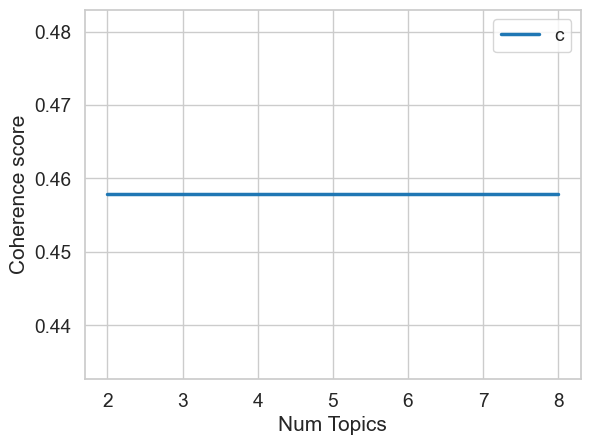

In [572]:
# Show graph

import matplotlib.pyplot as plt

limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best') #Using loc='best' is often convenient because it lets Matplotlib handle the positioning of the legend automatically, 
plt.show()



In [573]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4578
Num Topics = 4  has Coherence Value of 0.4578
Num Topics = 6  has Coherence Value of 0.4578
Num Topics = 8  has Coherence Value of 0.4578


In [574]:
steam_reviews_filtered2.to_csv('./topic_modelling.csv')

#### Sentiment Analysis

In [575]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [576]:
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon["lazy"] = -3.8

domain_words = {
    "unplayable": -4.0,
    "10/10": 2,
    "bad devs":-4.0,
    "FIX AUDIO": -4.0,
    "trash" : -4.0,
    "this game gets worse and worse" : -4.0,
    "super inconsistent" : -4.0,
    "Best battle royale game": 4,
    "Probably the most fun i've ever had out of a battle royale": 4,
    "best battle royale games":4,
    "pog":3.8,
    "gem":4,
    "Despite all bugs and glitches":0,
    "Dogshit":-4.0,
    "bugs":-4.0,
    
}

analyzer.lexicon.update(domain_words)

vader_lexicon = analyzer.lexicon

for word, score in list(vader_lexicon.items())[:100000]:  
    print(f"Word: {word}, Sentiment Score: {score}")

Word: $:, Sentiment Score: -1.5
Word: %), Sentiment Score: -0.4
Word: %-), Sentiment Score: -1.5
Word: &-:, Sentiment Score: -0.4
Word: &:, Sentiment Score: -0.7
Word: ( '}{' ), Sentiment Score: 1.6
Word: (%, Sentiment Score: -0.9
Word: ('-:, Sentiment Score: 2.2
Word: (':, Sentiment Score: 2.3
Word: ((-:, Sentiment Score: 2.1
Word: (*, Sentiment Score: 1.1
Word: (-%, Sentiment Score: -0.7
Word: (-*, Sentiment Score: 1.3
Word: (-:, Sentiment Score: 1.6
Word: (-:0, Sentiment Score: 2.8
Word: (-:<, Sentiment Score: -0.4
Word: (-:o, Sentiment Score: 1.5
Word: (-:O, Sentiment Score: 1.5
Word: (-:{, Sentiment Score: -0.1
Word: (-:|>*, Sentiment Score: 1.9
Word: (-;, Sentiment Score: 1.3
Word: (-;|, Sentiment Score: 2.1
Word: (8, Sentiment Score: 2.6
Word: (:, Sentiment Score: 2.2
Word: (:0, Sentiment Score: 2.4
Word: (:<, Sentiment Score: -0.2
Word: (:o, Sentiment Score: 2.5
Word: (:O, Sentiment Score: 2.5
Word: (;, Sentiment Score: 1.1
Word: (;<, Sentiment Score: 0.3
Word: (=, Sentiment Sc

In [577]:
steam_reviews_filtered2['compound_sentiment'] = steam_reviews_filtered['review'].map(lambda x: analyzer.polarity_scores(x)['compound'])


In [578]:
steam_reviews_filtered2.head()

,recommendationid,language,review,voted_up,steamid,playtime_at_review,review_length,review_processed,clean_review,clean_review_str,bigram_review,trigram_review,compound_sentiment
0,169339509.0,english,"Now with the new battle pass system, I'm delet...",0.0,76561198091477605,89667.0,17,now with the new battle pass system i'm deleti...,"[new, pas, system, deleting, well, player, bye]",new pas system deleting well player bye,"[new_pas, pas_system, system_deleting, deletin...","[new_pas_system, pas_system_deleting, system_d...",-0.2003
1,174544621.0,english,"I've been playing this game since release, and...",0.0,76561198009192271,105376.0,294,i've been playing this game since release and ...,"[playing, since, release, used, blast, initial...",playing since release used blast initial relea...,"[playing_since, since_release, release_used, u...","[playing_since_release, since_release_used, re...",-0.9845
2,168328105.0,english,Game freezes every session i play with the new...,0.0,76561198295880474,40421.0,13,game freezes every session i play with the new...,"[freeze, every, session, new, update, literall...",freeze every session new update literally unpl...,"[freeze_every, every_session, session_new, new...","[freeze_every_session, every_session_new, sess...",-0.5719
3,108917721.0,english,You open the game and finish your 3000 word es...,1.0,76561198016708638,33212.0,315,you open the game and finish your 3000 word es...,"[open, finish, word, essay, due, tomorrow, loa...",open finish word essay due tomorrow load main ...,"[open_finish, finish_word, word_essay, essay_d...","[open_finish_word, finish_word_essay, word_ess...",-0.7709
4,170215617.0,english,"Apex is like your neighbor's sister, she treat...",0.0,76561199442688562,75521.0,66,apex is like your neighbor's sister she treats...,"[neighbor, sister, treat, utmost, tenderness, ...",neighbor sister treat utmost tenderness bring ...,"[neighbor_sister, sister_treat, treat_utmost, ...","[neighbor_sister_treat, sister_treat_utmost, t...",0.3079


In [579]:
def compound_recommened(compound_sentiment):
    if compound_sentiment >= 0.0:
        return 1.0
    elif compound_sentiment < 0.0:
        return 0.0

In [580]:
steam_reviews_filtered2['compound_recommended'] = steam_reviews_filtered2['compound_sentiment'].map(lambda x: compound_recommened(x))

In [581]:
steam_reviews_filtered2[steam_reviews_filtered2['voted_up'] == 0.0].head(30)

,recommendationid,language,review,voted_up,steamid,playtime_at_review,review_length,review_processed,clean_review,clean_review_str,bigram_review,trigram_review,compound_sentiment,compound_recommended
0,169339509.0,english,"Now with the new battle pass system, I'm delet...",0.0,76561198091477605,89667.0,17,now with the new battle pass system i'm deleti...,"[new, pas, system, deleting, well, player, bye]",new pas system deleting well player bye,"[new_pas, pas_system, system_deleting, deletin...","[new_pas_system, pas_system_deleting, system_d...",-0.2003,0.0
1,174544621.0,english,"I've been playing this game since release, and...",0.0,76561198009192271,105376.0,294,i've been playing this game since release and ...,"[playing, since, release, used, blast, initial...",playing since release used blast initial relea...,"[playing_since, since_release, release_used, u...","[playing_since_release, since_release_used, re...",-0.9845,0.0
2,168328105.0,english,Game freezes every session i play with the new...,0.0,76561198295880474,40421.0,13,game freezes every session i play with the new...,"[freeze, every, session, new, update, literall...",freeze every session new update literally unpl...,"[freeze_every, every_session, session_new, new...","[freeze_every_session, every_session_new, sess...",-0.5719,0.0
4,170215617.0,english,"Apex is like your neighbor's sister, she treat...",0.0,76561199442688562,75521.0,66,apex is like your neighbor's sister she treats...,"[neighbor, sister, treat, utmost, tenderness, ...",neighbor sister treat utmost tenderness bring ...,"[neighbor_sister, sister_treat, treat_utmost, ...","[neighbor_sister_treat, sister_treat_utmost, t...",0.3079,1.0
5,147996275.0,english,Wanted to wait until 1000 hours to write anyth...,0.0,76561198136659949,60135.0,1145,wanted to wait until 1000 hours to write anyth...,"[wanted, wait, hour, write, anything, though, ...",wanted wait hour write anything though admitte...,"[wanted_wait, wait_hour, hour_write, write_any...","[wanted_wait_hour, wait_hour_write, hour_write...",-0.9950,0.0
6,169486802.0,english,Apex currently has:\n\n- audio issues\n- perfo...,0.0,76561198259124018,25755.0,446,apex currently has:\n\n- audio issues\n- perfo...,"[currently, ha, audio, issue, performance, iss...",currently ha audio issue performance issue net...,"[currently_ha, ha_audio, audio_issue, issue_pe...","[currently_ha_audio, ha_audio_issue, audio_iss...",0.2007,1.0
9,175061783.0,english,"Day 1 player... Over 2,000 hours in this game....",0.0,76561198900912234,112918.0,452,day 1 player over 2000 hours in this game even...,"[day, one, player, hour, even, hour, titanfall...",day one player hour even hour titanfall used h...,"[day_one, one_player, player_hour, hour_even, ...","[day_one_player, one_player_hour, player_hour_...",-0.9945,0.0
12,156031806.0,english,The latest Final Fantasy crossover event has r...,0.0,76561198011227693,18213.0,163,the latest final fantasy crossover event has r...,"[latest, final, fantasy, crossover, event, ha,...",latest final fantasy crossover event ha really...,"[latest_final, final_fantasy, fantasy_crossove...","[latest_final_fantasy, final_fantasy_crossover...",0.1322,1.0
13,154303457.0,english,I played this game for over 1600 Hours - i rea...,0.0,76561198109718571,101241.0,687,i played this game for over 1600 hours - i rea...,"[hour, really, story, character, represents, s...",hour really story character represents state b...,"[hour_really, really_story, story_character, c...","[hour_really_story, really_story_character, st...",0.9903,1.0
14,167005158.0,english,The game is now totally broken and not fun to ...,0.0,76561198258004808,253971.0,82,the game is now totally broken and not fun to ...,"[totally, broken, fun, anymore, hour, state, a...",totally broken fun anymore hour state ablosute...,"[totally_broken, broken_fun, fun_anymore, anym...","[totally_broken_fun, broken_fun_anymore, fun_a...",-0.9352,0.0


In [582]:
from sklearn.metrics import accuracy_score

accuracy_score(steam_reviews_filtered2['voted_up'], steam_reviews_filtered2['compound_recommended'])

0.7543316907350118